In [1]:
# ======================================
# 0. Core libs (DAY1~DAY9 공통)
# ======================================
import numpy as np
import pandas as pd

import shutil
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import matplotlib.font_manager as fm
from matplotlib import rcParams

# ======================================
# 1) Style FIRST (폰트보다 먼저)
# ======================================
plt.style.use("_mpl-gallery-nogrid")
sns.set_theme(style="white")
sns.set_style("ticks")
sns.set_context("notebook")

# ======================================
# 2) Font (NanumGothic) — style 적용 후 "고정"
# ======================================
FONT_DIR = Path(r"E:\Portfolio_ver1\seoul_pv_load_analysis\fonts")
FONT_PATH = FONT_DIR / "NanumGothic.ttf"

if not FONT_PATH.exists():
    raise FileNotFoundError(f"폰트 파일 없음: {FONT_PATH}")

fm.fontManager.addfont(str(FONT_PATH))
font_name = fm.FontProperties(fname=str(FONT_PATH)).get_name()

rcParams["font.family"] = font_name
rcParams["axes.unicode_minus"] = False

# (선택) 기본 글자 크기 통일
rcParams["font.size"] = 12
rcParams["axes.titlesize"] = 18
rcParams["axes.labelsize"] = 14
rcParams["xtick.labelsize"] = 12
rcParams["ytick.labelsize"] = 12

# 개별 객체용 (필요할 때만)
font_prop = fm.FontProperties(fname=str(FONT_PATH))

print("✅ Style+Font ready:", font_name)


✅ Style+Font ready: NanumGothic


### DAY 4: 전력 부하 vs 태양광 패턴 비교

**목적**
- 전력 수요와 태양광 발전 간 시간대 불일치 구조 확인

**주요 작업**
- 전력 부하 곡선과 PV 패턴 곡선 시각화
- PV로 직접 대응 불가 시간대 확인

**산출물**
- 덕 커브 구조 비교 그래프

In [ ]:
'''
DAY 4  목표
- DAY 4에서는 전력 수요와 태양광 발전 간의 시간대 불일치가
- 실제 운영 부담(Net Load)으로 어떻게 나타나는지를 정량적으로 확인하고,
- ESS 등 운영 자원이 개입해야 할 시간대와 규모를 데이터로 제시한다.
'''

In [2]:
# 경로 설정
PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / "data"
LOAD_FILE = DATA_DIR / "법정동별시간별전력사용량.csv"
OUT_DIR = PROJECT_ROOT / "outputs"
OUT_DIR.mkdir(exist_ok=True)
FIG_DIR = Path("figures")
FIG_DIR.mkdir(exist_ok=True)

SAVE_KWARGS = dict(
    dpi=300,
    bbox_inches="tight",
    pad_inches=0.1
)

if not LOAD_FILE.exists():
    raise FileNotFoundError(f"데이터 파일 없음 : {LOAD_FILE}")

# 데이터로드
df = pd.read_csv(LOAD_FILE, encoding = "utf-8-sig")

# datetime 생성
df["date"] = pd.to_datetime(df["USE_YM"], format = "%Y%m%d", errors = "coerce")
df["hour"] = (df["USE_HM"] // 100 - 1).astype("Int64")
df["datetime"] = df["date"] + pd.to_timedelta(df["hour"].fillna(0), unit = "h")

# value 생성
df["value"] = pd.to_numeric(df["FDRCT_VLD_KWH"].astype(str).str.replace(",", ""), errors = "coerce")
df_base = df[["datetime", "hour", "value"]].copy()

# DAY 2 산출물: 24h 평균 부하
load_profile_24h = (df_base.dropna(subset = ["value"]).groupby("hour", as_index = False)["value"].agg(load_mean = "mean").sort_values("hour"))
load_peak = load_profile_24h["load_mean"].max()

# DAY 3 산출물: PV 스케일
def make_pv_profile(hours = range(24), peak = 13, sigma = 2.3, sunrise = 7, sunset = 19):
    h = np.array(list(hours))
    pv = np.exp(-0.5 * ((h - peak) / sigma) ** 2)
    pv[(h < sunrise) | (h > sunset)] = 0
    return pv / pv.max()

pv_profile_24h = pd.DataFrame({"hour": range(24), "pv_norm": make_pv_profile()})
pv_ratio = 0.2 # DAY 3에서 쓴 대표 시나리오
pv_scaled_24h = pv_profile_24h.copy()
pv_scaled_24h["pv_kW"] = pv_scaled_24h["pv_norm"] * load_peak * pv_ratio

# DAY 4 준비완료!
print("===DAY 4 변수 준비 완료!===")
print("df_base:", df_base.shape)
print("load_profile_24h:", load_profile_24h.shape)
print("pv_profile_24h:", pv_profile_24h.shape)

===DAY 4 변수 준비 완료!===
df_base: (9754804, 3)
load_profile_24h: (24, 2)
pv_profile_24h: (24, 2)


In [3]:
# 1. Net Load 계산 (핵심)
# 정의: Net Load = Load - PV -> 태양광을 고려한 뒤, 계통이 실제로 감당해야 하는 부하

# 안전하게 다시 병합
net_df = (load_profile_24h.merge(pv_scaled_24h, on = "hour", how = "left").sort_values("hour"))
net_df["net_load"]  = net_df["load_mean"] - net_df["pv_kW"]
display(net_df)

,hour,load_mean,pv_norm,pv_kW,net_load
0,0,4828.966546,0.000000,0.000000,4828.966546
1,1,4436.061656,0.000000,0.000000,4436.061656
2,2,4301.931715,0.000000,0.000000,4301.931715
3,3,4069.172541,0.000000,0.000000,4069.172541
4,4,4467.956892,0.000000,0.000000,4467.956892
5,5,4570.492076,0.000000,0.000000,4570.492076
6,6,5000.093613,0.000000,0.000000,5000.093613
7,7,5677.409920,0.033285,50.908733,5626.501187
8,8,6575.992184,0.094142,143.988297,6432.003887
9,9,7246.801206,0.220405,337.104729,6909.696478


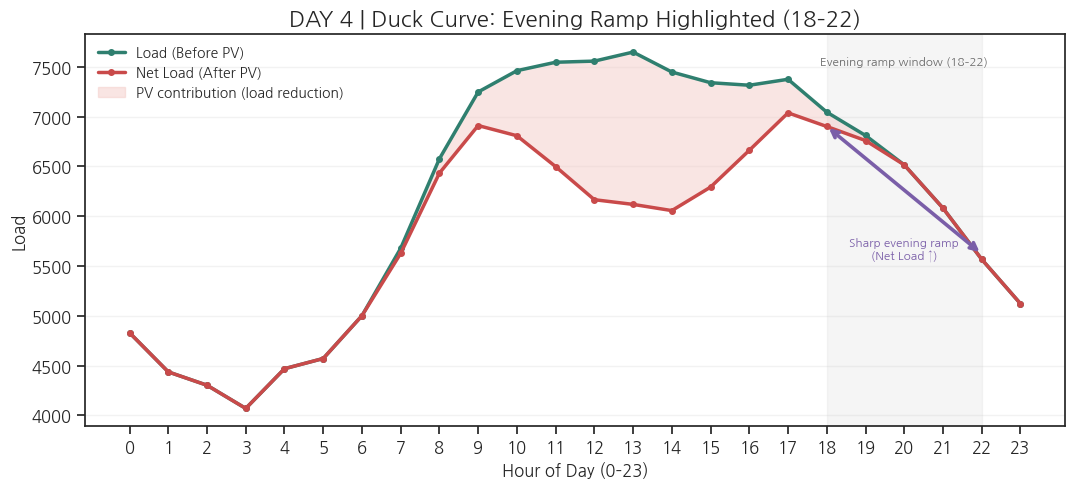

In [4]:
# 2. 덕커브 시각화
# =========================
# Colors / window
# =========================
LOAD_COLOR = "#2F7F6F"      # Before PV
NET_COLOR  = "#C94A4A"      # Net Load (after PV)
ZONE_COLOR = "#D9D9D9"      # Evening zone
RAMP_COLOR = "#7A5EA8"      # Ramp arrow/text
GAP_COLOR  = "#F2C6C2"      # Area between (Load - Net)

EV_START, EV_END = 18, 22

# =========================
# Ramp values (required)
# =========================
net_18 = float(net_df.loc[net_df["hour"] == EV_START, "net_load"].iloc[0])
net_22 = float(net_df.loc[net_df["hour"] == EV_END, "net_load"].iloc[0])

# =========================
# Font size tweaks (only for this figure)
# =========================
LABEL_FS = 12     # axis labels
TITLE_FS = 16     # title
NOTE_FS  = 8.5    # zone label + callout (down from 9)

# =========================
# Figure
# =========================
fig, ax = plt.subplots(figsize=(10, 4))

# --- Load (Before PV)
ax.plot(
    net_df["hour"], net_df["load_mean"],
    color=LOAD_COLOR, linewidth=2.5,
    marker="o", markersize=4,
    label="Load (Before PV)",
    zorder=3
)

# --- Net Load (After PV)
ax.plot(
    net_df["hour"], net_df["net_load"],
    color=NET_COLOR, linewidth=2.5,
    marker="o", markersize=4,
    label="Net Load (After PV)",
    zorder=4
)

# =========================
# Evening Ramp Zone shading
# =========================
ax.axvspan(EV_START, EV_END, color=ZONE_COLOR, alpha=0.25, zorder=0)

# Zone label (top-center)
ax.text(
    (EV_START + EV_END) / 2,
    0.93,
    f"Evening ramp window ({EV_START}–{EV_END})",
    ha="center", va="center",
    fontsize=NOTE_FS,
    color="dimgray",
    transform=ax.get_xaxis_transform(),
    zorder=10
)

# =========================
# (Key) Area fill between Load and Net Load (EV window only)
# =========================
ax.fill_between(
    net_df["hour"],
    net_df["net_load"],
    net_df["load_mean"],
    where=(net_df["load_mean"] >= net_df["net_load"]),
    color=GAP_COLOR,
    alpha=0.45,   # 전체 칠하니까 살짝만 낮춤
    label="PV contribution (load reduction)",
    zorder=1
)

# =========================
# Ramp arrow + callout (always on top)
# =========================
ax.annotate(
    "",
    xy=(EV_END, net_22 * 1.01),
    xytext=(EV_START, net_18),
    arrowprops=dict(
        arrowstyle="<->",
        lw=2.6,
        color=RAMP_COLOR
    ),
    zorder=20
)

# Callout text (smaller font)
ax.text(
    (EV_START + EV_END) / 2,
    0.45,
    "Sharp evening ramp\n(Net Load ↑)",
    color=RAMP_COLOR,
    fontsize=NOTE_FS,
    ha="center",
    va="center",
    transform=ax.get_xaxis_transform(),
    zorder=21
)

# =========================
# Axes / grid / legend
# =========================
ax.set_xlabel("Hour of Day (0–23)", fontsize=LABEL_FS)
ax.set_ylabel("Load", fontsize=LABEL_FS)
ax.set_xticks(np.arange(0, 24, 1))
ax.grid(axis="y", alpha=0.25)

ax.legend(frameon=False, loc="upper left", fontsize=10)

# =========================
# Title & save
# =========================
ax.set_title(
    f"DAY 4 | Duck Curve: Evening Ramp Highlighted ({EV_START}–{EV_END})",
    fontsize=TITLE_FS
)

plt.savefig(
    FIG_DIR / "DAY4_duck_curve_evening_ramp_gapfill_EN.png",
    **SAVE_KWARGS
)

plt.show()


In [5]:
# 3. 운영 관점 지표 1 - 잉여 / 부족 시간대
# ESS가 언제 필요하냐?
net_df["status"] = np.where(net_df["net_load"] > 0, "부족", "잉여 / 완화")
summary_time = (net_df.groupby("status")["hour"].count().rename("hours"))
display(summary_time)

status
부족    24
Name: hours, dtype: Int64

In [6]:
# 4. 운영 관점 지표 2 - 운영 부담 집중도
# 부담이 언제 가장 집중되냐?

# 저녁 피크 구간 정의 (운영 관점, 필요 시 조정)
peak_window = net_df[net_df["hour"].between(17, 20)]

total_net_load = net_df["net_load"].clip(lower = 0).sum()
peak_net_load = peak_window["net_load"].clip(lower = 0).sum()

peak_ratio = (peak_net_load / total_net_load) * 100

print(f"저녁 피크(17 ~ 20시) Net Load 비중: {peak_ratio:.1f}%")

저녁 피크(17 ~ 20시) Net Load 비중: 19.5%


In [7]:
# 5. ESS 필요성 "데이터로" 보여주기

# 잉여(완화)와 부족 규모 비교
surplus_energy = (-net_df["net_load"].clip(upper = 0)).sum() # 잉여 총량
deficit_energy = (net_df["net_load"].clip(lower = 0)).sum() # 부족 총량

print(f"낮 시간대 잉여(완화) 총량: {surplus_energy:.1f}")
print(f"저녁 중심 부족 총량: {deficit_energy:.1f}")

낮 시간대 잉여(완화) 총량: 0.0
저녁 중심 부족 총량: 139217.0


In [8]:
# 6. ESS 논리를 더 선명하게 만드는 방법
pv_ratios = [0.2, 0.3, 0.4]

results = []

for pv_ratio in pv_ratios:
    pv_tmp = pv_profile_24h.copy()
    pv_tmp["pv_kW"] = pv_tmp["pv_norm"] * load_peak * pv_ratio

    tmp = load_profile_24h.merge(pv_tmp, on = "hour")
    tmp["net_load"] = tmp["load_mean"] - tmp["pv_kW"]

    surplus = (-tmp["net_load"].clip(upper = 0)).sum() # 잉여 총량
    deficit = (tmp["net_load"].clip(lower = 0)).sum() # 부족 총량

    results.append({
        "PV_ratio_%": int(pv_ratio * 100),
        "Surplus_energy": round(surplus, 1),
        "Deficit_energy": round(deficit, 1)
    })

    scenario_df = pd.DataFrame(results)
    display(scenario_df)

,PV_ratio_%,Surplus_energy,Deficit_energy
0,20,0.0,139217.0


,PV_ratio_%,Surplus_energy,Deficit_energy
0,20,0.0,139217.0
1,30,0.0,134827.4


,PV_ratio_%,Surplus_energy,Deficit_energy
0,20,0.0,139217.0
1,30,0.0,134827.4
2,40,0.0,130437.9


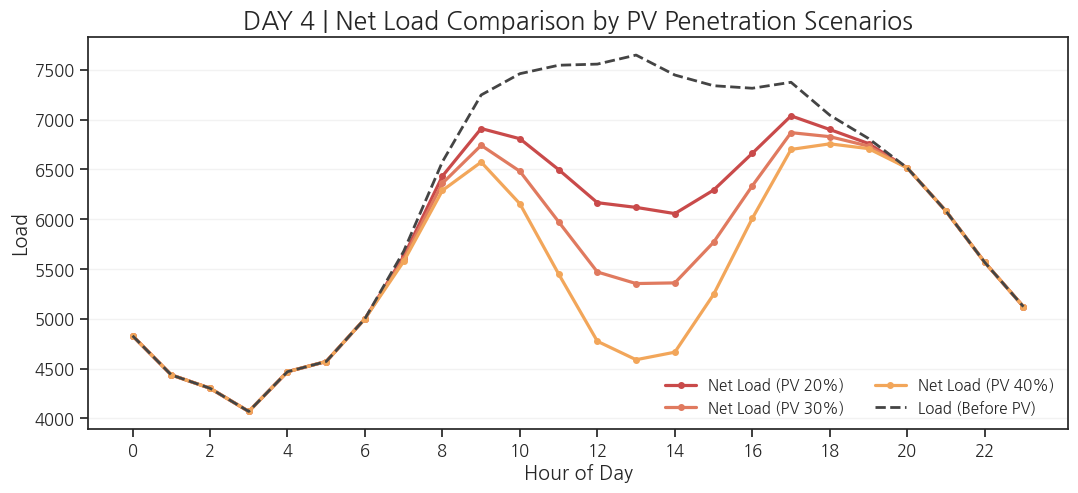

In [9]:
# 7. 덕 커브 비교 시각화
# =========================
# 색상 팔레트 (톤다운, 단계별)
# =========================
PV_COLORS = [
    "#C94A4A",  # 10% (가장 진한 문제 강조)
    "#E07A5F",  # 20%
    "#F2A65A",  # 30%
    "#81B29A",  # 40%
]

BASELINE_COLOR = "#444444"  # Before PV (검정 대신 차콜)

# =========================
# Figure
# =========================
plt.figure(figsize=(10, 4))

# PV ratio 시나리오별 Net Load
for pv_ratio, color in zip(pv_ratios, PV_COLORS):
    pv_tmp = pv_profile_24h.copy()
    pv_tmp["pv_kW"] = pv_tmp["pv_norm"] * load_peak * pv_ratio

    tmp = load_profile_24h.merge(pv_tmp, on="hour")
    tmp["net_load"] = tmp["load_mean"] - tmp["pv_kW"]

    plt.plot(
        tmp["hour"],
        tmp["net_load"],
        color=color,
        linewidth=2.3,
        marker="o",
        markersize=4,
        label=f"Net Load (PV {int(pv_ratio * 100)}%)"
    )

# Before PV (기준선)
plt.plot(
    load_profile_24h["hour"],
    load_profile_24h["load_mean"],
    color=BASELINE_COLOR,
    linestyle="--",
    linewidth=2,
    label="Load (Before PV)"
)

# =========================
# 축 / 그리드 / 범례
# =========================
plt.xlabel("Hour of Day")
plt.ylabel("Load")
plt.xticks(np.arange(0, 24, 2))
plt.grid(axis="y", alpha=0.25)
plt.legend(frameon=False, ncol=2)

# =========================
# 제목
# =========================
plt.title("DAY 4 | Net Load Comparison by PV Penetration Scenarios")

# =========================
# 저장
# =========================
plt.savefig(
    FIG_DIR / "DAY4_net_load_by_pv_ratio.png",
    **SAVE_KWARGS
)

plt.show()


In [10]:
# 8. DATA 4 Final Narrative Generator
# - scenario_df 결과를 기반으로 해석 문장을 자동 생성

def _fmt(x):
    # None / NaN 방어
    try:
        return f"{float(x):,.1f}"
    except Exception:
        return str(x)
    
def generate_day4_narrative(scenario_df, pv_base = 20, pv_high = 40):
    # scenario_df columns expected:
    # - PV_ratio_% (int)
    # - Surplus_energy (float)
    # - Deficit_energy (float)

    # 행 찾기
    base_row = scenario_df.loc[scenario_df["PV_ratio_%"] == pv_base]
    high_row = scenario_df.loc[scenario_df["PV_ratio_%"] == pv_high]

    if base_row.empty or high_row.empty:
        raise ValueError(f"scenario_df에 {pv_base}% 또는 {pv_high}% 시나리오가 없습니다.")
    
    base_surplus = float(base_row["Surplus_energy"].iloc[0])
    base_deficit = float(base_row["Deficit_energy"].iloc[0])

    high_surplus = float(high_row["Surplus_energy"].iloc[0])
    high_deficit = float(high_row["Deficit_energy"].iloc[0])

    # 잉여 발생이 시작되는 최소 비율 찾기
    positive_surplus = scenario_df[scenario_df["Surplus_energy"] > 0]
    if positive_surplus.empty:
        start_ratio = None
    else:
        start_ratio = int(positive_surplus.sort_values("PV_ratio_%").iloc[0]["PV_ratio_%"])

    lines = []

    # 1) 20% 기준 결론
    if base_surplus <= 0:
        lines.append(
            f"PV 비율 {pv_base}% 시나리오에서는 순부하가 음(-)의 영역으로 전환되지 않아 잉여전력은 발생하지 않았으며, "
            f"태양광은 부하를 완화하되 저장이 필요한 수준의 잉여를 만들지는 못했다.")
    else:
        lines.append(
            f"PV 비율 {pv_base}% 시나리오에서도 낮 시간대 잉여 전력(총 {_fmt(base_surplus)})이 관측되어, "
            f"시간대 조정 자원의 필요성이 확인되었다.")
        
    # 2) 잉여 발생 시작 지점 언급
    if start_ratio is None:
        lines.append(
            "검토한 시나리오 범위 내에서는 낮 시간대 잉여 전력이 충분히 발생하지 않아, "
            "설비 확대만으로 운영 부담을 해소하기 어려운 구조임을 시사한다.")
    else:
        lines.append(
            f"PV 비율이 {start_ratio}% 이상으로 확대될 경우 낮 시간대 잉여 전력이 발생하기 시작하며, "
            "이는 저녁 피크 부족과 시간적으로 분리되어 나타난다.")
        
    # 3) 고비율(예: 40%) 수치 기반 보강
    lines.append(
        f"예를 들어 PV 비율 {pv_high}% 시나리오에서는 낮 잉여 총량이 {_fmt(high_surplus)}, "
        f"부족 총량이 {_fmt(high_deficit)}로 나타나, 에너지의 '총량'이 아니라 '시간 이동'이 핵심 과제로 드러났다.")
    
    # 4) 운영 / ESS 연결
    lines.append(
        "따라서 설비 확장만으로는 한계가 있으며, 낮 시간대 잉여를 저녁 피크로 이동시키는 ESS와 같은 "
        "시간대 조정 기반 운영 자원의 병행이 필요함을 시사한다.")
    
    return "\n".join([f"- {s}" for s in lines])

# 실행
final_text = generate_day4_narrative(scenario_df, pv_base = 20, pv_high = 40)
print("===DAY 4 최종 해석 문장===")
print(final_text)

===DAY 4 최종 해석 문장===
- PV 비율 20% 시나리오에서는 순부하가 음(-)의 영역으로 전환되지 않아 잉여전력은 발생하지 않았으며, 태양광은 부하를 완화하되 저장이 필요한 수준의 잉여를 만들지는 못했다.
- 검토한 시나리오 범위 내에서는 낮 시간대 잉여 전력이 충분히 발생하지 않아, 설비 확대만으로 운영 부담을 해소하기 어려운 구조임을 시사한다.
- 예를 들어 PV 비율 40% 시나리오에서는 낮 잉여 총량이 0.0, 부족 총량이 130,437.9로 나타나, 에너지의 '총량'이 아니라 '시간 이동'이 핵심 과제로 드러났다.
- 따라서 설비 확장만으로는 한계가 있으며, 낮 시간대 잉여를 저녁 피크로 이동시키는 ESS와 같은 시간대 조정 기반 운영 자원의 병행이 필요함을 시사한다.


In [11]:
# ============================================================
# DAY4 Validation Cell (최종본 품질보증)
# - 이 셀만 통과하면: 시간축/병합/NetLoad/시나리오 계산 흐름 OK
# ============================================================

# 0) 필수 객체 존재 확인
required_objs = ["df_base", "load_profile_24h", "pv_profile_24h", "pv_scaled_24h"]
missing = [o for o in required_objs if o not in globals()]
if missing:
    raise NameError(f"필수 변수 누락: {missing}")

# 1) hour 범위/형 확인
assert load_profile_24h["hour"].between(0, 23).all(), "load_profile_24h에 0~23 범위 밖 hour 존재"
assert pv_profile_24h["hour"].between(0, 23).all(), "pv_profile_24h에 0~23 범위 밖 hour 존재"

# 2) 24시간 완성 여부 (가장 중요)
assert set(load_profile_24h["hour"]) == set(range(24)), "load_profile_24h가 24시간(0~23) 완성되지 않음"
assert set(pv_profile_24h["hour"]) == set(range(24)), "pv_profile_24h가 24시간(0~23) 완성되지 않음"

# 3) 병합 안전성 (left merge 권장)
net_check = load_profile_24h.merge(pv_scaled_24h, on="hour", how="left").sort_values("hour")
assert net_check.shape[0] == 24, "병합 결과가 24행이 아님 (hour 누락 가능)"
assert net_check["pv_kW"].isna().sum() == 0, "pv_kw에 NaN 존재 (PV 데이터 누락)"

# 4) Net Load 계산 결과 유효성
net_check["net_load"] = net_check["load_mean"] - net_check["pv_kW"]
assert net_check["net_load"].notna().all(), "net_load에 NaN 존재"
assert (net_check["pv_kW"] >= 0).all(), "pv_kw에 음수 존재 (비정상)"
# load_mean은 데이터 특성상 0 이상이어야 정상
assert (net_check["load_mean"] >= 0).all(), "load_mean에 음수 존재 (비정상)"

# 5) 시나리오 비교가 계산 가능한지 (20/30/40 기본 검증)
test_ratios = [0.2, 0.3, 0.4]
for r in test_ratios:
    pv_tmp = pv_profile_24h.copy()
    pv_tmp["pv_kW"] = pv_tmp["pv_norm"] * load_profile_24h["load_mean"].max() * r

    tmp = load_profile_24h.merge(pv_tmp, on="hour", how="left")
    tmp["net_load"] = tmp["load_mean"] - tmp["pv_kW"]

    surplus = (-tmp["net_load"].clip(upper=0)).sum()
    deficit = ( tmp["net_load"].clip(lower=0)).sum()

    assert surplus >= 0, "surplus가 음수로 계산됨 (로직 이상)"
    assert deficit >= 0, "deficit이 음수로 계산됨 (로직 이상)"

print("✅ DAY4 검증 통과: 시간축/병합/NetLoad/시나리오 로직 모두 정상입니다.")


✅ DAY4 검증 통과: 시간축/병합/NetLoad/시나리오 로직 모두 정상입니다.


In [13]:
locals().keys()

dict_keys(['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__builtin__', '__builtins__', '_ih', '_oh', '_dh', 'In', 'Out', 'get_ipython', 'exit', 'quit', 'open', '_', '__', '___', '__vsc_ipynb_file__', '_i', '_ii', '_iii', '_i1', 'LOAD_COLOR', 'NET_COLOR', 'ZONE_COLOR', 'RAMP_COLOR', 'GAP_COLOR', 'EV_START', 'EV_END', '_i2', 'np', 'pd', 'shutil', 'datetime', 'plt', 'sns', 'Path', 'fm', 'rcParams', 'FONT_DIR', 'FONT_PATH', 'font_name', 'font_prop', '_i3', 'PROJECT_ROOT', 'DATA_DIR', 'LOAD_FILE', 'OUT_DIR', 'FIG_DIR', 'SAVE_KWARGS', 'df', 'df_base', 'load_profile_24h', 'load_peak', 'make_pv_profile', 'pv_profile_24h', 'pv_ratio', 'pv_scaled_24h', '_i4', 'net_df', '_i5', 'net_18', 'net_22', 'LABEL_FS', 'TITLE_FS', 'NOTE_FS', 'fig', 'ax', '_i6', 'summary_time', '_i7', 'peak_window', 'total_net_load', 'peak_net_load', 'peak_ratio', '_i8', 'surplus_energy', 'deficit_energy', '_i9', 'pv_ratios', 'results', 'pv_tmp', 'tmp', 'surplus', 'deficit', 'scenario_df', '_i10', 'PV_COLO

In [12]:
# outputs/day4_net_load_base.csv
base_cols = ["hour", "load_mean", "pv_norm", "net_load"]
avail = [c for c in base_cols if c in net_df.columns]

day4_out = net_df[avail].copy()
day4_out.to_csv(OUT_DIR / "DAY4_net_load_base.csv",
                index=False, encoding="utf-8-sig")
print("Saved:", "DAY4_net_load_base.csv", "| cols:", avail)

Saved: DAY4_net_load_base.csv | cols: ['hour', 'load_mean', 'pv_norm', 'net_load']


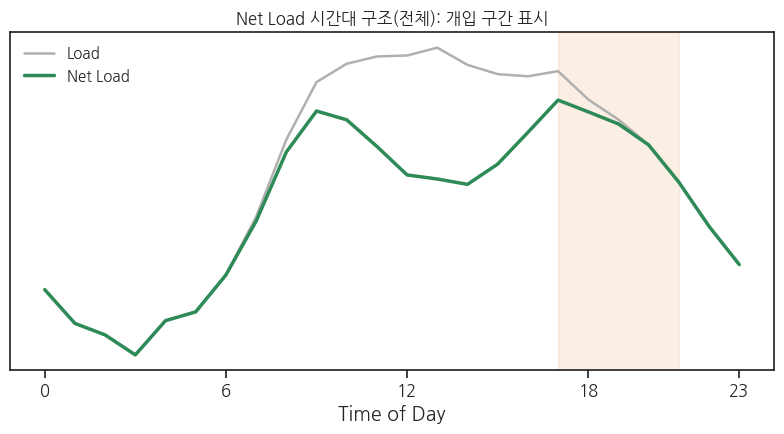

In [13]:
hours = net_df["hour"].astype(int)
load = net_df["load_mean"]
net_load = net_df["net_load"]

start_h, end_h = 17, 21
mask = (hours >= start_h) & (hours <= end_h)

plt.figure(figsize=(8, 4.5))
plt.plot(hours, load, color="#B0B0B0", linewidth=1.8, label="Load")
plt.plot(hours, net_load, color="#2E8B57", linewidth=2.5, label="Net Load")
plt.axvspan(start_h, end_h, color="#F4C2A1", alpha=0.28)

plt.xticks([0, 6, 12, 18, 23])
plt.yticks([])
plt.xlabel("Time of Day")
plt.title("Net Load 시간대 구조(전체): 개입 구간 표시", fontsize=12)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


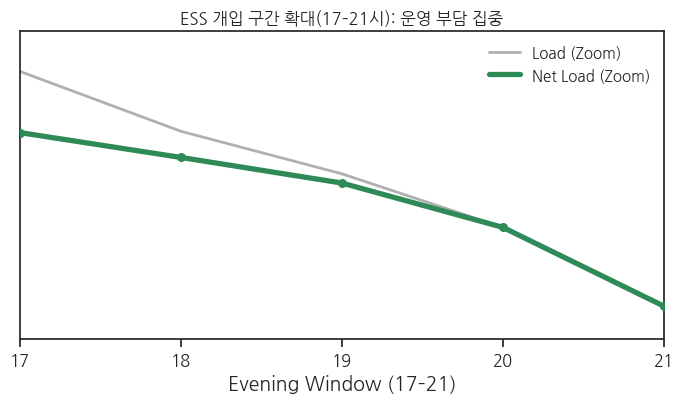

In [14]:
hours = net_df["hour"].astype(int)
load = net_df["load_mean"]
net_load = net_df["net_load"]

start_h, end_h = 17, 21
mask = (hours >= start_h) & (hours <= end_h)

# 줌인 범위에서 y축도 자동으로 타이트하게 잡기
y_min = min(load[mask].min(), net_load[mask].min())
y_max = max(load[mask].max(), net_load[mask].max())

plt.figure(figsize=(7, 4.2))
plt.plot(hours[mask], load[mask], color="#B0B0B0", linewidth=2.0, label="Load (Zoom)")
plt.plot(hours[mask], net_load[mask], color="#2E8B57", linewidth=3.8, label="Net Load (Zoom)")
plt.scatter(hours[mask], net_load[mask], s=30, color="#2E8B57", zorder=5)

plt.xlim(start_h, end_h)
plt.ylim(y_min * 0.97, y_max * 1.03)

plt.xticks(list(range(start_h, end_h + 1)))
plt.yticks([])  # 해석용이면 수치 제거
plt.xlabel("Evening Window (17–21)")
plt.title("ESS 개입 구간 확대(17–21시): 운영 부담 집중", fontsize=12)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


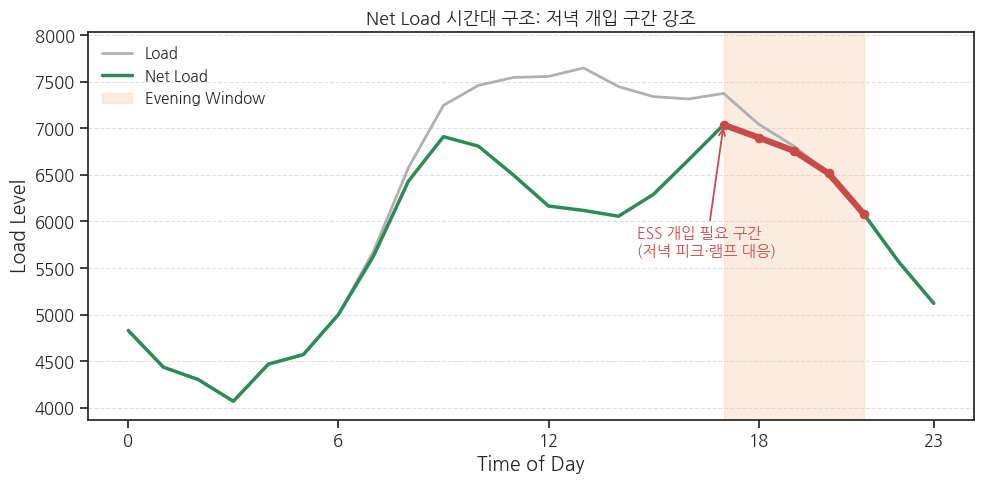

In [17]:
# =========================
# 데이터
# =========================
hours = net_df["hour"].astype(int)
load = net_df["load_mean"]
net_load = net_df["net_load"]

# =========================
# 개입 구간 설정
# =========================
start_h, end_h = 17, 21
mask = (hours >= start_h) & (hours <= end_h)

# 개입 구간 내 피크 지점
peak_idx = net_df.loc[mask, "net_load"].idxmax()
peak_h = int(net_df.loc[peak_idx, "hour"])
peak_v = float(net_df.loc[peak_idx, "net_load"])

# =========================
# Figure
# =========================
plt.figure(figsize=(10, 5))

# 전체 곡선
plt.plot(hours, load,
         color="#B0B0B0",
         linewidth=2,
         label="Load")

plt.plot(hours, net_load,
         color="#2E8B57",
         linewidth=2.5,
         label="Net Load")

# 개입 구간 음영
plt.axvspan(start_h, end_h,
            color="#F4C2A1",
            alpha=0.30,
            label="Evening Window")

# 개입 구간 Net Load 강조 (굵게)
plt.plot(hours[mask], net_load[mask],
         color="#C94A4A",
         linewidth=4.5,
         zorder=5)

# 개입 구간 포인트 마커
plt.scatter(hours[mask], net_load[mask],
            s=35,
            color="#C94A4A",
            zorder=6)

# ESS 개입 주석
plt.annotate(
    "ESS 개입 필요 구간\n(저녁 피크·램프 대응)",
    xy=(peak_h, peak_v),
    xycoords="data",
    xytext=(0.62, 0.50),          # ← 축 비율 좌표
    textcoords="axes fraction",   # ← 핵심
    arrowprops=dict(
        arrowstyle="->",
        lw=1.3,
        color="#C94A4A"
    ),
    fontsize=11,
    color="#C94A4A",
    ha="left",
    va="top"
)

# =========================
# 축 & 그리드 (중요 포인트)
# =========================
plt.xticks([0, 6, 12, 18, 23])
plt.xlabel("Time of Day")

plt.ylabel("Load Level")   # 단위는 일부러 생략
plt.grid(
    axis="y",              # 가로 그리드만
    linestyle="--",
    linewidth=0.8,
    alpha=0.6
)

# Y축 범위 살짝 여유
y_min = min(load.min(), net_load.min())
y_max = max(load.max(), net_load.max())
plt.ylim(y_min * 0.95, y_max * 1.05)

# =========================
# 마무리
# =========================
plt.title("Net Load 시간대 구조: 저녁 개입 구간 강조", fontsize=13)
# =========================
# 저장
# =========================
plt.savefig(
    FIG_DIR / "DAY4_net_load_ESS_time.png",
    **SAVE_KWARGS
)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()
